# Overview
## The problem
Sidewalks may need repair for a variety of reasons, but one known cause is due to unruly trees and roots that cause buckling. Tree maintenance belongs to the Department of Parks and Recreation (DPR),  but sidewalk repair is largely a chore for the Department of Transportation. The two agencies work together through [Sidewalk Repair programs](https://www.nycgovparks.org/services/forestry/sidewalk-repair), helping property owners to repair damaged sidewalks and keep trees healthy. 

311, the main source for government non-emergency services, provides information, refers residents to where they can find the information they need, and submits service requests. In 2016, there were over 12,000 calls related to “Root/Sewer/Sidewalk Condition” and general “Sidewalk Condition.” When trees damage sidewalks, the DPR submits a foresty work order to make the fix. Can 311 service requests hint at other ways the agencies could work together on sidewalk repair, to anticipage damage sooner or predict where trees may cause sidewalk damage next? What are the data-driven stories we can tell about the relationship between 311 sidewalk complaint data and forestry work orders on the streets overall?

## The data:

* [2016 311 Service Request data](https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9)
* [(DPR) 2016 Forestry Work Order data](https://data.cityofnewyork.us/Environment/Forestry-Work-Orders/bdjm-n7q4/data)

___

### Here we go!

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
%pylab inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# Import two datasets
# 2016 311 data related to sidewalk complaints
df_311sidewalk = pd.read_csv("311_trees_sidewalks.csv")
# 2016 DPR Forestry Work Orders related to street tree maintenance, removal, etc.
df_forestry = pd.read_csv("Forestry_Work_Orders_16.csv")

In [3]:
# Parsing our 311 data 

# Removing Staten Island (outliers), and unspecified locations 
df_311sidewalk = df_311sidewalk[~df_311sidewalk['Borough'].isin(['STATEN ISLAND', 'Unspecified'])]
# Removing Noise complaint type that contains "tree"
df_311sidewalk = df_311sidewalk[~df_311sidewalk['Complaint Type'].isin(['Noise - Street/Sidewalk'])]
# Removing Community Boards that are unspecified or out of range
df_311sidewalk = df_311sidewalk[~df_311sidewalk['Community Board'].isin(['Unspecified QUEENS', 'Unspecified BROOKLYN', 'Unspecified BRONX', 'Unspecified MANHATTAN', '55 BROOKLYN', '82 QUEENS', '64 MANHATTAN', '28 BRONX', '26 BRONX', '83 QUEENS', '27 BRONX'])]
# Let's see what we're workinging with
df_311sidewalk.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
2,32306830,01/01/2016 12:10:19 AM,01/04/2016 02:06:26 PM,DOT,Department of Transportation,Sidewalk Condition,Sidewalk Grating - Defective,Sidewalk,10022.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.756497,-73.972362,"(40.75649659469117, -73.97236197495663)"
64,32313119,01/01/2016 11:08:55 AM,NaN,DPR,Department of Parks and Recreation,Root/Sewer/Sidewalk Condition,Trees and Sidewalks Program,Street,11233.0,383 DECATUR STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.682064,-73.928139,"(40.68206430464392, -73.92813912969066)"
73,32312315,01/01/2016 05:38:36 PM,01/04/2016 09:38:04 AM,DPR,Department of Parks and Recreation,Root/Sewer/Sidewalk Condition,Trees and Sidewalks Program,Street,11416.0,101-20 92 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.683222,-73.848394,"(40.683222018452824, -73.84839398411884)"
74,32311074,01/01/2016 05:43:47 PM,01/04/2016 09:36:59 AM,DPR,Department of Parks and Recreation,Root/Sewer/Sidewalk Condition,Trees and Sidewalks Program,Street,11416.0,101-20 92 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.683222,-73.848394,"(40.683222018452824, -73.84839398411884)"
118,32320069,01/02/2016 10:12:26 AM,01/04/2016 12:15:06 PM,DOT,Department of Transportation,Sidewalk Condition,Blocked - Construction,Sidewalk,11214.0,152 BAY 40 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.594470,-73.989594,"(40.59446995210811, -73.98959382576125)"


In [4]:
# Checking that we're only working with the compliant types that we want for this project
df_311sidewalk['Complaint Type'].value_counts()

Root/Sewer/Sidewalk Condition    6758
Sidewalk Condition               5812
Name: Complaint Type, dtype: int64

In [6]:
# Switching 'Community Board' to the same format as our other data set. 
# This is not the prettiest way to do this
df_311sidewalk['Community Board'].replace({'01 MANHATTAN':'101','02 MANHATTAN':'102','03 MANHATTAN':'103','04 MANHATTAN':'104','05 MANHATTAN':'105','06 MANHATTAN':'106','07 MANHATTAN':'107','08 MANHATTAN':'108','09 MANHATTAN':'109','10 MANHATTAN':'110','11 MANHATTAN':'111','12 MANHATTAN':'112'},inplace=True)
df_311sidewalk['Community Board'].replace({'01 BRONX':'201','02 BRONX':'202','03 BRONX':'203','04 BRONX':'204','05 BRONX':'205','06 BRONX':'206','07 BRONX':'207','08 BRONX':'208','09 BRONX':'209','10 BRONX':'210','11 BRONX':'211','12 BRONX':'212'},inplace=True)
df_311sidewalk['Community Board'].replace({'01 BROOKLYN':'301','02 BROOKLYN':'302','03 BROOKLYN':'303','04 BROOKLYN':'304','05 BROOKLYN':'305','06 BROOKLYN':'306','07 BROOKLYN':'307','08 BROOKLYN':'308','09 BROOKLYN':'309','10 BROOKLYN':'310','11 BROOKLYN':'311','12 BROOKLYN':'312','13 BROOKLYN':'313','14 BROOKLYN':'314','15 BROOKLYN':'315','16 BROOKLYN':'316','17 BROOKLYN':'317','18 BROOKLYN':'318'},inplace=True)
df_311sidewalk['Community Board'].replace({'01 QUEENS':'401','02 QUEENS':'402','03 QUEENS':'403','04 QUEENS':'404','05 QUEENS':'405','06 QUEENS':'406','07 QUEENS':'407','08 QUEENS':'408','09 QUEENS':'409','10 QUEENS':'410','11 QUEENS':'411','12 QUEENS':'412','13 QUEENS':'413','14 QUEENS':'414'},inplace=True)


In [7]:
# Now, let's group by the number of sidewalk-related complaints in each community board
df_311sidewalk['sidewalk_complaints'] = df_311sidewalk.groupby('Community Board')['Community Board'].transform('count')
# Resetting index to make it easier to work with
df_311sidewalk = df_311sidewalk.groupby(["Community Board", "sidewalk_complaints"]).size().reset_index()

In [8]:
# Getting rid of columns we don't need
df_311sidewalk = df_311sidewalk[['Community Board', 'sidewalk_complaints']]
# Bingo
df_311sidewalk.head()

,Community Board,sidewalk_complaints
0,101,152
1,102,227
2,103,152
3,104,235
4,105,228


In [9]:
# Let's look at descriptive statistics, to see what complaints are like overall in each community district 
# This doesn't tell us a ton because comparing community districts isn't apples to apples in this case
# But it does give us an idea of what's 'normal' when it comes to sidewalk complaints in each area
df_311sidewalk.sidewalk_complaints.describe()

count     56.000000
mean     224.464286
std      148.524741
min       43.000000
25%      114.250000
50%      190.500000
75%      299.500000
max      669.000000
Name: sidewalk_complaints, dtype: float64

___

In [10]:
# Now, let's get our forestry work orders in the same format so we can merge our data sets

# Removing Staten Island
df_forestry = df_forestry[~df_forestry['Borough'].isin(['Staten Island'])]
# Removing WO Types that are completely unrelated to the relationship we're curious about
df_forestry = df_forestry[~df_forestry['WOType'].isin(['Prune', 'Hanging Limb', 'Prune - Traffic 10 Day', 'Tree Down - Other', 'Limb Down - Driveway', 'Rescue/Preservation - Tree', 'Tree Down - Other', 'Limb Down - Driveway', 'Rescue/Preservation - Tree', 'Limb Down - Car', 'Resistograph','Prune - Traffic 20 Day', 'Tree Down - Car', 'Tree Down - House', 'Planting Space', 'Limb Down - House', 'Tree Down - Park (Active)', 'Tree Down - Driveway', 'Limb Down - Park (Passive)', 'Limb Down - Park (Active)', 'Rescue/Preservation - Space', 'Pest and Disease', 'Tree Down - Park (Passive)', 'Court Appearance - Tree', 'Court Appearance - Space', 'Tree Removal - ALB', 'Root Slice', 'Debris Removal - Misc. Wood', 'Limb Down - Other', 'Split Tree', 'Misc. Work', 'Tree Plant - Street Tree', 'Tree Plant - Park Tree'])]


In [11]:
# Let's create one dataframe that looks at all potentially related work order types to see if it helps our model. 
# We'll create a second dataframe that look *only* at 'Tree and Sidewalk Repair' work orders
df_fwo = df_forestry
# Massaging into the same format, with Community Board as key
df_fwo['wo_count'] = df_fwo.groupby('Community Board')['Community Board'].transform('count')
df_fwo = df_fwo.groupby(["Community Board", "wo_count"]).size().reset_index()
df_fwo = df_fwo[['Community Board', 'wo_count']]
df_fwo.head()

,Community Board,wo_count
0,101,79
1,102,261
2,103,268
3,104,196
4,105,106


In [12]:
# Leaving in several complaint types we're going to factor in. Are some that are less sidewalk specific related?
# Removing more trees and stumps in that CD lead to buckling sidewalks? Can 311 data help predict where these WO will be?
df_forestry['WOType'].value_counts()

Tree Removal                       13457
Stump Removal                       2134
Limb Down - Sidewalk                2071
Tree and Sidewalk Repair            1979
Tree Plant - Street Tree Block      1644
Tree Down - Sidewalk                 601
Limb Down - Street                   590
Stump Removal for Tree Planting      296
Tree Removal - Uprooted              238
Tree Removal for Tree Planting       188
Tree Down - Street                   176
Name: WOType, dtype: int64

In [13]:
# Descriptive statistics regarding work orders (types outlined above) per community district. 
# Again, we can't put too much stock in this since comm districts are very different
df_fwo.wo_count.describe()

count      63.000000
mean      371.015873
std       282.791585
min         1.000000
25%       188.000000
50%       317.000000
75%       486.500000
max      1430.000000
Name: wo_count, dtype: float64

In [14]:
# Now, this dataframe will look only at sidewalk repair work orders
df_sidewalk_wo = df_forestry
# Massaging into the same format, with Community Board as key
df_sidewalk_wo = df_sidewalk_wo.loc[df_sidewalk_wo['WOType'] == 'Tree and Sidewalk Repair']
df_sidewalk_wo['sidewalk_wo_count'] = df_sidewalk_wo.groupby('Community Board')['Community Board'].transform('count')
df_sidewalk_wo = df_sidewalk_wo.groupby(["Community Board", "sidewalk_wo_count"]).size().reset_index()
df_sidewalk_wo = df_sidewalk_wo[['Community Board', 'sidewalk_wo_count']]
df_sidewalk_wo.head()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Community Board,sidewalk_wo_count
0,102,8
1,103,1
2,104,3
3,107,2
4,108,1


In [15]:
# Let's check the descriptive statistics for this dataframe as well.
# The average of about 37 sidewalk repair work orders per community district is higher than I'd anticipated!
df_sidewalk_wo.sidewalk_wo_count.describe()

count     53.000000
mean      37.339623
std       35.827011
min        1.000000
25%       12.000000
50%       30.000000
75%       50.000000
max      159.000000
Name: sidewalk_wo_count, dtype: float64

In [16]:
# Merge all related forestry work orders with 311 sidewalk complaints
df_311sidewalk["Community Board"] = df_fwo["Community Board"]
All_wo = pd.merge(df_311sidewalk, df_fwo, on='Community Board')
All_wo.head()


,Community Board,sidewalk_complaints,wo_count
0,101,152,79
1,102,227,261
2,103,152,268
3,104,235,196
4,105,228,106


In [17]:
# Merge forestry work orders for sidewalk repairs specifically with 311 sidewalk complaints
df_311sidewalk["Community Board"] = df_sidewalk_wo["Community Board"]
SW_wo = pd.merge(df_311sidewalk, df_sidewalk_wo, on="Community Board")
SW_wo.head()

,Community Board,sidewalk_complaints,sidewalk_wo_count
0,102.0,152,8
1,103.0,227,1
2,104.0,152,3
3,107.0,235,2
4,108.0,228,1


___

## Modeling

In [18]:
# A simple linear regression model shows that the model can only explain about 8% of the relationship 
# Not great...hmmm. 
lmAll = smf.ols('wo_count~sidewalk_complaints', data=All_wo).fit()
lmAll.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               wo_count   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     4.876
Date:                Mon, 09 Oct 2017   Prob (F-statistic):             0.0315
Time:                        23:18:36   Log-Likelihood:                -381.02
No. Observations:                  56   AIC:                             766.0
Df Residuals:                      54   BIC:                             770.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept             250.4239     54.121      4.627      0.000       141.918   358.930
sidewalk_complaints     0.4452      0.202      2.208      0.032         0.041     0.849
==============================================================================
Omnibus:                        9.450   Durbin-Watson:                   1.623
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                8.890
Skew:                           0.884   Prob(JB):                       0.0117
Kurtosis:                       3.827   Cond. No.                         489.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

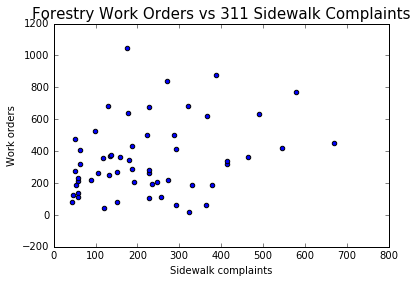

In [19]:
# Let's see what this relationship looks like on a scatter plot
plt.scatter(All_wo.sidewalk_complaints, All_wo.wo_count)
plt.title('Forestry Work Orders vs 311 Sidewalk Complaints', fontsize = 15)
plt.xlabel('Sidewalk complaints')
plt.ylabel('Work orders')

In [20]:
# Let's see if looking at just sidewalk repair work orders is a bit more related
# Ooof. R squared here is even lower! And not even close to significant.
lmSW = smf.ols('sidewalk_wo_count~sidewalk_complaints', data=SW_wo).fit()
lmSW.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      sidewalk_wo_count   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     2.927
Date:                Mon, 09 Oct 2017   Prob (F-statistic):             0.0932
Time:                        23:18:38   Log-Likelihood:                -262.89
No. Observations:                  53   AIC:                             529.8
Df Residuals:                      51   BIC:                             533.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              24.0429      9.152      2.627      0.011         5.670    42.416
sidewalk_complaints     0.0625      0.037      1.711      0.093        -0.011     0.136
==============================================================================
Omnibus:                       25.549   Durbin-Watson:                   1.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.490
Skew:                           1.619   Prob(JB):                     9.79e-10
Kurtosis:                       5.881   Cond. No.                         475.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

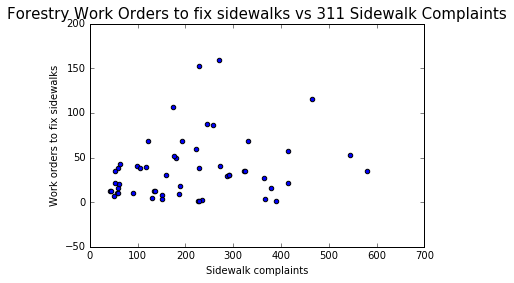

In [21]:
# How does this one look? No apparent relationship.
plt.scatter(SW_wo.sidewalk_complaints, SW_wo.sidewalk_wo_count)
plt.title('Forestry Work Orders to fix sidewalks vs 311 Sidewalk Complaints', fontsize = 15)
plt.xlabel('Sidewalk complaints')
plt.ylabel('Work orders to fix sidewalks')

 ___

# Visualization
We know there's not a huge relationship between 311 complaints about sidewalks and DPR work order to tend to street trees. Let's look at the proportion of work orders to complaints in each community district to see if there's anything interesting to explore further, or if it can give us clues about what we should focus on if we were to dive deeper. 

In [22]:
# Now let's see if I can teach myself geopandas!
# Bringing in community district map
import geopandas as gpd
nycd = gpd.read_file('nycd.shp')
nycd.head()

,BoroCD,Shape_Leng,Shape_Area,geometry
0,311,51549.557738,1.031778e+08,"POLYGON ((991748.3937988281 161084.9552001953,..."
1,314,49291.791502,8.217567e+07,"POLYGON ((996375.2443847656 177931.1611938477,..."
2,313,65746.939737,8.814953e+07,"POLYGON ((988770.7620239258 156350.5123901367,..."
3,310,44794.111421,1.113147e+08,"POLYGON ((975283.3026123047 173918.8842163086,..."
4,312,52245.830711,9.952550e+07,"POLYGON ((992187.4083862305 175455.467590332, ..."


In [23]:
# Renaming columns so I can bring in my data
nycd.rename(columns={'BoroCD': 'Community Board'}, inplace=True)
# And merging with my data set that looks at all tree related work orders to visualize, since it had the highest R-squared
nycd = nycd.merge(All_wo, on='Community Board')
nycd.head()

# cool, it worked!

,Community Board,Shape_Leng,Shape_Area,geometry,sidewalk_complaints,wo_count
0,311,51549.557738,1.031778e+08,"POLYGON ((991748.3937988281 161084.9552001953,...",228,280
1,314,49291.791502,8.217567e+07,"POLYGON ((996375.2443847656 177931.1611938477,...",222,499
2,313,65746.939737,8.814953e+07,"POLYGON ((988770.7620239258 156350.5123901367,...",106,262
3,310,44794.111421,1.113147e+08,"POLYGON ((975283.3026123047 173918.8842163086,...",64,406
4,312,52245.830711,9.952550e+07,"POLYGON ((992187.4083862305 175455.467590332, ...",414,317


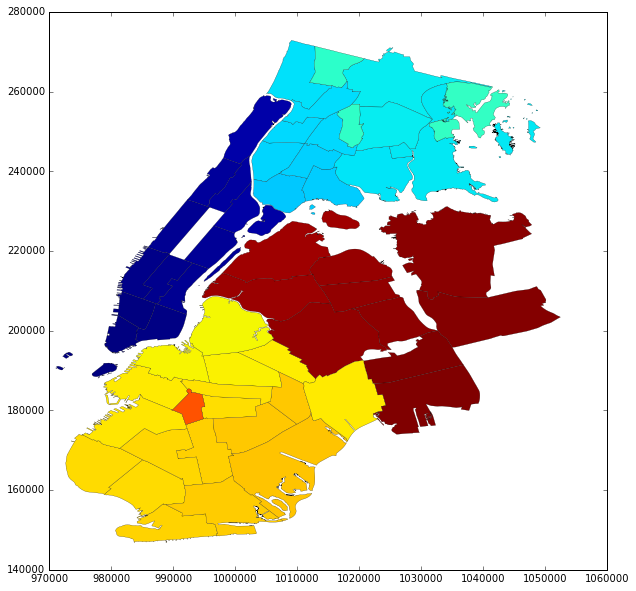

In [24]:
#Now let's make a map and see what happens
f, ax = plt.subplots(figsize=(10,10))
nycd.plot(column='Community Board', linewidth=0.2, ax = ax)

In [25]:
# creating a new column that looks at the proportion of forestry work orders and sidewalk complaints                                
All_wo['proportion'] = All_wo['wo_count']/All_wo['sidewalk_complaints']
All_wo.head(5)
         

,Community Board,sidewalk_complaints,wo_count,proportion
0,101,152,79,0.519737
1,102,227,261,1.149780
2,103,152,268,1.763158
3,104,235,196,0.834043
4,105,228,106,0.464912


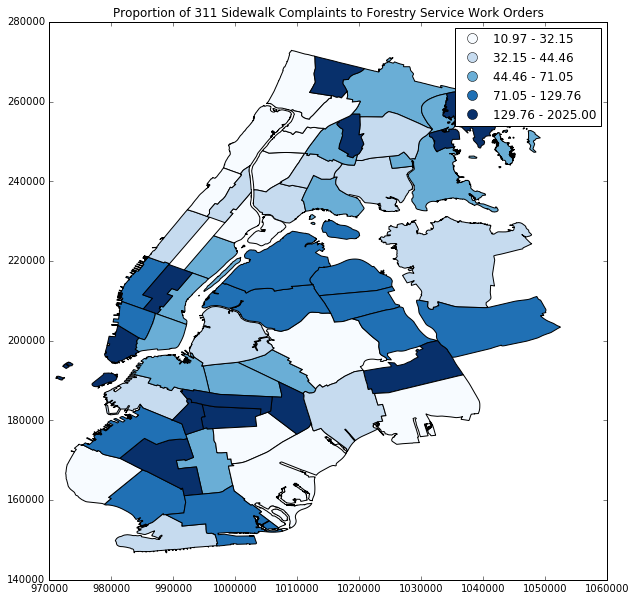

In [26]:
# Now to map the proportion. We know that there isn't much of a relationship, but let's see what we can see.
f, ax = plt.subplots(figsize=(10,10))
nycd['proportion'] = (nycd.sidewalk_complaints / nycd.wo_count)*100
ax.set_title('Proportion of 311 Sidewalk Complaints to Forestry Service Work Orders')
nycd.plot(column='proportion', cmap='Blues', scheme='quantiles', ax = ax, legend=True);

# vmin, vmax = -1, 2
# ax = nycd.plot(column='proportion', colormap='hot', vmin=vmin, vmax=vmax)
# cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
# sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm._A = []
# fig.colorbar(sm, cax=cax)


This graph doesn't show us much because there isn't much of a relationship, but it does make us look more closely at a few different community districts. Queens 10, for example, is a huge outliner. Are people less likely to use the 311 service in that area, or is there a ton of work orders for a specific planning reason? Looking into some of these outlier districts would be a potential next step for our analysis. 

It's worth mentioning that if I were a consultant for an agency on this project, I'd hire someone who has worked with geopandas before to support with visualizations so they're more meaningful. 

___

## Analysis and next steps

Much of my analysis on this project and the models are inserted as comments in the code. There is not a significant relationship between sidewalk complaints to 311 and sidewalk repair work orders. In its current state (and my current data science skill level) this model could not help predict where work orders are likely to be filed with regard to trees/sidewalk repair, or help assign resources. 

It's interesting that the model that included the other types of tree-related work orders (not only sidewalk repair) explained the relationship with 311 complaint data more. Some community districts are closer to parks and have a more verdant baseline, making their forestry work orders higher on average to start. On the flip side, some districts are less residential; while trees may affect sidewalk health, they may go unreported through the 311 service. Normalizing by 311 use could help us understand this relationship better. Normalizing by trees per district would also be helpful, as some districts require more work on trees simply because they contain more vegitation. 

Regardless, there is much to continue to explore, and more potential ways to tweak the model. 

## Other data considersations and new questions
This project and analysis brought up many more questions for further research that weren't within scope. Some questions include: 

* Consider excluding tree removal as a WO type input?
* Consider playing with more combinations of WO types to understand which are most related to 311 data?
* Look at what else sidewalk complaints from 311 could be referring to (not broken, but graffittied, for example). Can we filter down further? 
* What are other considerations to help us normalize between community board? Are there better ways to compare areas around the city, like zip code? 
